## Sección de Librerías

In [32]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme()
#Optimización multiobjetivo 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population

#Finanzas 
import yfinance as yf
import yesg

#Plugins
from tqdm import tqdm
from itertools import compress
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras
from Plugins import DS

## Descarga de lista de activos a escoger
Esta sección puede dar errores si se pierde la conexión, solo es necesario volver a ejecutar. 

In [33]:
assets = pd.read_csv('Indices/tickers_dowjones.csv', index_col=0)['0'].tolist()

## Primera parte, obtención de los activos para el portafolio

In [34]:
ohlc = yf.download(assets, period="2y") 
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  30 of 30 completed


In [35]:
prices.tail()

AAPL        AMGN         AXP          BA         CAT  \
Date                                                                     
2023-06-27  188.059998  222.610001  168.190002  209.429993  240.690002   
2023-06-28  189.250000  221.309998  169.779999  210.720001  241.869995   
2023-06-29  189.589996  221.160004  172.080002  211.830002  244.240005   
2023-06-30  193.970001  222.020004  174.199997  211.160004  246.050003   
2023-07-03  192.460007  225.009995  175.440002  210.919998  247.330002   

                   CRM       CSCO         CVX        DIS        DOW  ...  \
Date                                                                 ...   
2023-06-27  208.820007  50.860001  153.529999  89.059998  52.570000  ...   
2023-06-28  212.169998  50.869999  154.919998  88.830002  52.959999  ...   
2023-06-29  210.429993  51.209999  156.240005  88.949997  53.240002  ...   
2023-06-30  211.259995  51.740002  157.350006  89.279999  53.259998  ...   
2023-07-03  211.649994  51.820000  157.210007  90.500000  53.779999  ...   

                   MRK        MSFT         NKE          PG         TRV  \
Date                                                                     
2023-06-27  113.320000  334.570007  113.610001  150.020004  172.589996   
2023-06-28  112.440002  335.850006  113.029999  149.990005  168.369995   
2023-06-29  113.540001  335.049988  113.370003  149.380005  170.990005   
2023-06-30  115.389999  340.540009  110.370003  151.740005  173.660004   
2023-07-03  114.330002  337.989990  109.110001  152.500000  173.089996   

                   UNH           V         VZ        WBA         WMT  
Date                                                                  
2023-06-27  482.559998  227.339996  36.549999  28.639999  154.490005  
2023-06-28  474.450012  227.960007  36.820000  29.080000  155.330002  
2023-06-29  476.440002  234.320007  36.990002  28.370001  154.279999  
2023-06-30  480.640015  237.479996  37.189999  28.490000  157.179993  
2023-07-03  477.880005  237.970001  37.279999  29.020000  158.199997  

[5 rows x 30 columns]

In [36]:
returns, assets_info= pre_processing.get_assets_info(prices, 99, log_returns=True, drop_per_esg=True)
assets_info #Los rendimientos están con signo al revés 

100%|██████████| 30/30 [00:05<00:00,  5.91it/s]


exp_risk  exp_return  esg_score
AAPL  0.296876   -0.158730      0.167
VZ    0.199888    0.153868      0.185
V     0.267590   -0.003891      0.161
UNH   0.229228   -0.090391      0.175
TRV   0.225834   -0.091054      0.205
PG    0.185414   -0.082554      0.266
NKE   0.344607    0.182707      0.170
MSFT  0.304332   -0.107827      0.152
MRK   0.221835   -0.223612      0.218
MMM   0.255002    0.292070      0.336
MCD   0.173243   -0.141173      0.248
KO    0.169438   -0.088946      0.226
JPM   0.266486   -0.003482      0.290
JNJ   0.160148   -0.012666      0.251
INTC  0.364603    0.222981      0.173
IBM   0.214367   -0.053476      0.148
HON   0.222008    0.004426      0.293
HD    0.272441   -0.009590      0.125
GS    0.273176    0.036963      0.262
DIS   0.324687    0.327913      0.149
CVX   0.283914   -0.247526      0.376
CSCO  0.252103   -0.015564      0.121
CRM   0.402333    0.084265      0.132
CAT   0.304684   -0.096201      0.342
BA    0.399364    0.056811      0.347
AXP   0.327362   -0.028478      0.184
AMGN  0.205196    0.007176      0.220
WBA   0.288414    0.203240      0.183
WMT   0.216671   -0.077369      0.246

In [37]:
best_assets = ArchievingStrategies.get_best_opt(assets_info.iloc[:, :2], 1e-6)
best_assets

29it [00:00, 14502.78it/s]


exp_risk  exp_return
MRK  0.221835   -0.223612
MCD  0.173243   -0.141173
KO   0.169438   -0.088946
JNJ  0.160148   -0.012666
CVX  0.283914   -0.247526

In [38]:
fig = my_plotting.plot_assets_plotly(assets_info, best_assets)
fig.show()

## Segunda Parte, Definición del Problema

In [39]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns[best_assets.index], assets_info.loc[best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES)

In [40]:
from finquant import efficient_frontier
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
ef_R = ef.efficient_frontier()

## Tercera parte, utilizar distintos muestreos

In [41]:
eps = np.array([0.01,0.01])
colors = ['#7F7F7F', 'rgb(141,160,203)', 'rgb(27,158, 119)']

### Markowitz Directed-Search

In [42]:
#Primer paso generar la población eficiente 
def get_Markowitz_directions(size, steps): 
    X_ef = DS.efficient_frontier_weights(ef, size)
    F_ef, ESG_ef = pymoo_extras.eval_weights(portfolio_problem, X_ef)
    FA_ef =  pymoo_extras.annualised_portfolio_quantities(F_ef)
    FA_ef_best = ArchievingStrategies.get_best_opt(FA_ef, 1e-6)
    X_ef= X_ef[FA_ef_best.index]
    ds = DS.DirectedSearch(X_ef[:], PROFITS, RISK, eps, learn_rate=0.001, n_iter=1000)
    X_ef_new = ds.directed_search_full_space(steps)
    return X_ef_new[:]

In [43]:
X_ef = get_Markowitz_directions(1000, 15)
F_ef, ESG_ef = pymoo_extras.eval_weights(portfolio_problem, X_ef)
FA_ef =  pymoo_extras.annualised_portfolio_quantities(F_ef)
FA_ef_best = ArchievingStrategies.get_best_opt(FA_ef, 1e-6)
FA_ef_best_eps = ArchievingStrategies.get_best_opt_eps(FA_ef, 1e-6, eps)
print('Total', FA_ef.shape)
print('Mejores', FA_ef_best.shape)
print('Eps-Mejores', FA_ef_best_eps.shape)

1000it [00:00, 11235.72it/s]
9225it [00:00, 16322.25it/s]
9225it [00:06, 1321.36it/s]

Total (9225, 2)
Mejores (1116, 2)
Eps-Mejores (9108, 2)


In [44]:
frames = [FA_ef, FA_ef_best_eps, FA_ef_best]
labels = ['All (Markowitz+DirectedSearch)', 'PQ-eps', 'PQ']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

### Con pesos uniformes

In [45]:
X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=17)
F_das, ESG_das = pymoo_extras.eval_weights(portfolio_problem, X_das)
FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
FA_das_best = ArchievingStrategies.get_best_opt(FA_das, 1e-6)
FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
print('Total', FA_das.shape)
print('Mejores', FA_das_best.shape)
print('Eps-Mejores', FA_das_best_eps.shape)


5985it [00:00, 21831.75it/s]
5985it [00:02, 2884.10it/s]

Total (5985, 2)
Mejores (83, 2)
Eps-Mejores (3499, 2)


In [46]:
frames = [FA_das, FA_das_best_eps, FA_das_best]
labels = ['All (Das-Dennis)', 'PQ-eps', 'PQ']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

### Con Algoritmos Evolutivos

In [47]:
from pymoo.termination import get_termination
termination = get_termination("n_gen", 300)
from pymoo.algorithms.moo.nsga2 import NSGA2
nsgaii = NSGA2(pop_size=40,repair=pymoo_extras.Portfolio_Repair())
from pymoo.algorithms.moo.sms import SMSEMOA
smsemoa = SMSEMOA(pop_size=40, repair=pymoo_extras.Portfolio_Repair())

#### Con NSGA-II

In [48]:
X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii, 1e-6)
FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
print('Total', FA_nsgaii.shape)
print('Mejores', FA_nsgaii_best.shape)
print('Eps-Mejores', FA_nsgaii_best_eps.shape)

12000it [00:01, 11123.56it/s]
12000it [00:12, 977.26it/s]

Total (12000, 2)
Mejores (1637, 2)
Eps-Mejores (10721, 2)


In [49]:
frames = [FA_nsgaii, FA_nsgaii_best_eps, FA_nsgaii_best]
labels = ['All (NSGA-II)', 'PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

#### Con SMS-EMOA

In [50]:
X_smsemoa, F_smsemoa, ESG_smsemoa =pymoo_extras.get_weights_with_pymoo(portfolio_problem, smsemoa, termination)
FA_smsemoa =  pymoo_extras.annualised_portfolio_quantities(F_smsemoa)
FA_smsemoa_best = ArchievingStrategies.get_best_opt(FA_smsemoa, 1e-6)
FA_smsemoa_best_eps = ArchievingStrategies.get_best_opt_eps(FA_smsemoa, 1e-6, eps)
print('Total', FA_smsemoa.shape)
print('Mejores', FA_smsemoa_best.shape)
print('Eps-Mejores', FA_smsemoa_best_eps.shape)

12000it [00:02, 5821.45it/s]
12000it [00:17, 667.32it/s]

Total (12000, 2)
Mejores (2421, 2)
Eps-Mejores (11416, 2)


In [51]:
frames = [FA_smsemoa, FA_smsemoa_best_eps, FA_smsemoa_best]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

## Evaluación 

In [52]:
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
from pymoo.indicators.gd import GD
from sklearn.preprocessing import MinMaxScaler
def get_pfa(name,  fun): 
    if name[0]=='*':
        X_ = fun()
        print(X_.shape)
        F_, ESG_ = pymoo_extras.eval_weights(portfolio_problem, X_)
    else: 
        X_, F_, ESG_ =pymoo_extras.get_weights_with_pymoo(portfolio_problem, fun, termination)
    FA_ = pymoo_extras.annualised_portfolio_quantities(F_)
    #FA_best = ArchievingStrategies.get_best_opt(FA_, 1e-6)
    FA_best_eps = ArchievingStrategies.get_best_opt_eps(FA_, 1e-6, eps)
    return FA_best_eps.to_numpy()

def invert_sign(list_pfa): 
    L = []
    for s in list_pfa:
        s1 = s.copy()
        s1[:, 1] = -s1[:,1]
        L.append(s1)   
    return L  

def eval_GD(pf, list_pfa):  
    ind = GD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]   

def eval_IGD(pf, list_pfa): 
    ind = IGD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]  

def eval_HV(ref_point, list_pfa): 
    scaler = MinMaxScaler()
    Ftest = np.vstack(list_pfa)
    scaler.fit(Ftest)
    ind = HV(ref_point=ref_point)
    return [ind(scaler.transform(A)) for A in list_pfa]

algs = {'*Markowitz' : lambda : get_Markowitz_directions(1000, 15), 
        '*das-dennis': lambda : get_reference_directions("das-dennis", len(PROFITS), n_partitions=17), 
        'nsgaii': nsgaii, 
        'sms-emoa':smsemoa}

def full_evaluation(iters, algs, pf, ref_point):
    metric_eval = {'GD': [], 'IGD': [], 'HV': []}
    metrics = {'GD': lambda x: eval_GD(pf, x), 
               'IGD':lambda x: eval_IGD(pf, x), 
               'HV': lambda x: eval_HV(ref_point, x)}
    for i in range(iters): 
        results = [ get_pfa(name, par) for name, par in algs.items()]
        for indicator in metrics.keys(): 
            metric_eval[indicator].append(metrics[indicator](results[:]))
    
    metric_eval_means = {}
    for indicator in metric_eval.keys(): 
        metric_eval_means[indicator+'mean']=np.mean( np.array(metric_eval[indicator]), axis=0)
        metric_eval_means[indicator+'std'] = np.std( np.array(metric_eval[indicator]), axis=0)
    
    return pd.DataFrame(metric_eval_means, index = algs.keys())

In [53]:
evaluation = full_evaluation(20, algs, ef_R, np.array([1.1,1.1]))
evaluation

1000it [00:00, 10416.77it/s]


(9225, 5)


9225it [00:12, 762.87it/s] 


(5985, 5)


5985it [00:02, 1995.45it/s]
12000it [00:16, 706.80it/s]
12000it [00:18, 653.44it/s]
1000it [00:00, 8928.76it/s]


(9225, 5)


9225it [00:11, 816.62it/s] 


(5985, 5)


5985it [00:02, 2191.12it/s]
12000it [00:16, 710.44it/s]
12000it [00:17, 690.83it/s]
1000it [00:00, 8064.65it/s]


(9225, 5)


9225it [00:11, 820.29it/s] 


(5985, 5)


5985it [00:02, 2193.75it/s]
12000it [00:19, 619.89it/s]
12000it [00:17, 677.54it/s]
1000it [00:00, 10752.83it/s]


(9225, 5)


9225it [00:12, 752.93it/s] 


(5985, 5)


5985it [00:02, 2329.46it/s]
12000it [00:15, 789.84it/s]
12000it [00:16, 729.85it/s]
1000it [00:00, 9542.55it/s]


(9225, 5)


9225it [00:10, 912.29it/s] 


(5985, 5)


5985it [00:02, 2286.58it/s]
12000it [00:14, 800.50it/s]
12000it [00:16, 733.10it/s]
1000it [00:00, 9897.99it/s]


(9225, 5)


9225it [00:10, 910.65it/s] 


(5985, 5)


5985it [00:02, 2300.40it/s]
12000it [00:15, 785.36it/s]
12000it [00:16, 717.96it/s]
1000it [00:00, 11387.20it/s]


(9225, 5)


9225it [00:11, 797.11it/s] 


(5985, 5)


5985it [00:02, 2174.96it/s]
12000it [00:16, 711.04it/s]
12000it [00:18, 661.56it/s]
1000it [00:00, 9326.02it/s]


(9225, 5)


9225it [00:12, 750.77it/s] 


(5985, 5)


5985it [00:02, 2045.86it/s]
12000it [00:16, 717.22it/s]
12000it [00:21, 547.31it/s]
1000it [00:00, 8620.69it/s]


(9225, 5)


9225it [00:13, 683.69it/s] 


(5985, 5)


5985it [00:03, 1735.34it/s]
12000it [00:18, 647.86it/s]
12000it [00:21, 557.15it/s]
1000it [00:00, 7751.73it/s]


(9225, 5)


9225it [00:12, 756.49it/s] 


(5985, 5)


5985it [00:03, 1851.66it/s]
12000it [00:22, 544.82it/s]
12000it [00:21, 553.46it/s]
1000it [00:00, 8928.82it/s]


(9225, 5)


9225it [00:07, 1244.51it/s]


(5985, 5)


5985it [00:01, 3024.64it/s]
12000it [00:10, 1147.72it/s]
12000it [00:12, 977.08it/s]
1000it [00:00, 8394.50it/s]


(9225, 5)


9225it [00:07, 1156.68it/s]


(5985, 5)


5985it [00:02, 2971.20it/s]
12000it [00:16, 718.59it/s]
12000it [00:19, 630.68it/s]
1000it [00:00, 10309.29it/s]


(9225, 5)


9225it [00:12, 741.88it/s] 


(5985, 5)


5985it [00:03, 1812.19it/s]
12000it [00:20, 597.42it/s]
12000it [00:21, 563.78it/s]
1000it [00:00, 8695.53it/s]


(9225, 5)


9225it [00:15, 603.09it/s] 


(5985, 5)


5985it [00:03, 1825.55it/s]
12000it [00:18, 662.25it/s]
12000it [00:18, 646.72it/s]
1000it [00:00, 7812.86it/s]


(9225, 5)


9225it [00:15, 603.76it/s] 


(5985, 5)


5985it [00:05, 1032.34it/s]
12000it [00:19, 615.99it/s]
12000it [00:31, 377.70it/s]
1000it [00:00, 9174.80it/s]


(9225, 5)


9225it [00:14, 645.50it/s] 


(5985, 5)


5985it [00:02, 2021.28it/s]
12000it [00:20, 583.80it/s]
12000it [00:22, 539.28it/s]
1000it [00:00, 8928.93it/s]


(9225, 5)


9225it [00:14, 656.12it/s] 


(5985, 5)


5985it [00:03, 1608.87it/s]
12000it [00:18, 642.18it/s]
12000it [00:21, 545.57it/s]
1000it [00:00, 9259.32it/s]


(9225, 5)


9225it [00:12, 755.70it/s] 


(5985, 5)


5985it [00:02, 2042.65it/s]
12000it [00:18, 664.11it/s]
12000it [00:21, 570.17it/s]
1000it [00:00, 9259.48it/s]


(9225, 5)


9225it [00:12, 761.20it/s] 


(5985, 5)


5985it [00:02, 2138.26it/s]
12000it [00:16, 742.65it/s]
12000it [00:18, 638.60it/s]
1000it [00:00, 10638.48it/s]


(9225, 5)


9225it [00:11, 817.87it/s] 


(5985, 5)


5985it [00:02, 2209.99it/s]
12000it [00:16, 719.47it/s]
12000it [00:17, 669.30it/s]


GDmean         GDstd   IGDmean        IGDstd    HVmean  \
*Markowitz   0.002278  8.673617e-19  0.012289  3.469447e-18  1.099922   
*das-dennis  0.006519  3.469447e-18  0.003419  4.336809e-19  1.094101   
nsgaii       0.003414  1.054424e-04  0.007395  1.963701e-03  1.099759   
sms-emoa     0.002525  1.775211e-04  0.009877  1.544406e-03  1.100113   

                    HVstd  
*Markowitz   1.083938e-07  
*das-dennis  1.077565e-07  
nsgaii       6.048048e-05  
sms-emoa     2.106674e-04

## Gráficas de Interés Muestreo Ganador

In [54]:
X, F, ESG =pymoo_extras.get_weights_with_pymoo(portfolio_problem,smsemoa, termination)
FA =  pymoo_extras.annualised_portfolio_quantities(F)
FA_best = ArchievingStrategies.get_best_opt(FA, 1e-6)
FA_best_eps = ArchievingStrategies.get_best_opt_eps(FA, 1e-6, eps)

FA_3D = FA_best_eps.copy()
FA_3D['exp_esg'] = ESG[FA_best_eps.index]
FA_3D_best       = ArchievingStrategies.get_best_opt(FA_3D, 1e-6)

print('Total', FA.shape)
print('Mejores', FA_best.shape)
print('Eps-Mejores', FA_best_eps.shape)
print('Mejores 3D', FA_3D_best.shape)

12000it [00:01, 7561.47it/s]
12000it [00:11, 1004.60it/s]
11351it [00:02, 3903.38it/s]

Total (12000, 2)
Mejores (2380, 2)
Eps-Mejores (11351, 2)
Mejores 3D (4148, 3)


In [55]:
frames = [FA, FA_best_eps, FA_best]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
colors = ['#7F7F7F', 'rgb(141,160,203)', 'rgb(27,158, 119)']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

In [56]:
## Correciones de signos 
#En dos objetivos
FA_best['exp_return'] = -FA_best['exp_return']
FA_best['exp_esg'] =  ESG[FA_best.index] 
#En tres objetivos
FA_3D_best['exp_return'] = - FA_3D_best['exp_return']
FA_3D['exp_return'] = - FA_3D['exp_return']
FA_3D['Type'] = 'PQ-eps 2obj'
FA_3D.loc[FA_3D_best.index, 'Type']='PQ 3obj'

In [57]:
fig = px.scatter_3d(FA_3D.sort_values(by='Type'), x='exp_risk', y='exp_return', z='exp_esg',
                color_discrete_sequence=['rgb(27,158, 119)','rgb(141,160,203)'],
                color='Type', width=800, height=800, 
                labels = {'exp_risk':'Riesgo Anual Esperado', 
                          'exp_return': 'Retorno Anual Esperado', 
                          'exp_esg': 'ESG score'})
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
)
fig.show()

In [58]:
fig = px.scatter(FA_3D_best, x='exp_risk', y='exp_return', color='exp_esg',
                 labels = {'exp_risk':'Riesgo Anual Esperado', 
                          'exp_return': 'Retorno Anual Esperado', 
                          'exp_esg': 'ESG score'})
fig.add_trace(go.Scatter(x=ef_R[:,0], y=ef_R[:,1],
                    mode='lines',
                    name='Markowitz', 
                    marker_color='#222A2A'), 
                 )
fig.update_layout(coloraxis_colorbar_y=0.45)
fig.show()

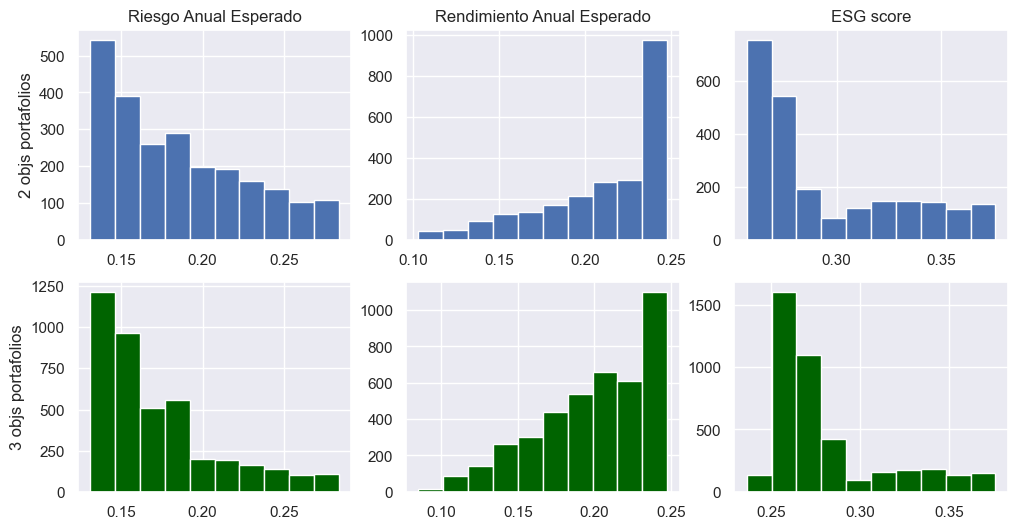

In [59]:
fig, ax = plt.subplots(2,3, figsize= (12,6))
ax[0][0].set_ylabel('2 objs portafolios')
ax[1][0].set_ylabel('3 objs portafolios')
ax[0][0].set_title('Riesgo Anual Esperado')
ax[0][1].set_title('Rendimiento Anual Esperado')
ax[0][2].set_title('ESG score')
for i in range(3): 
    FA_best.iloc[:, i].hist(ax=ax[0][i])
    FA_3D_best.iloc[:, i].hist(ax=ax[1][i], color='darkgreen')


In [60]:
X_best = X[FA_best.index]
X_3D_best = X[FA_3D_best.index]
X_best_means = np.mean(X_best, axis=0)
X_3D_best_means = np.mean(X_3D_best, axis=0)


In [61]:
assets_proportion = assets_info.loc[best_assets.index]
assets_proportion['Aportación 2obj']= X_best_means 
assets_proportion['Aportación 3obj']= X_3D_best_means

Text(0.5, 1.0, 'Composición de Portafolios 3 objs')

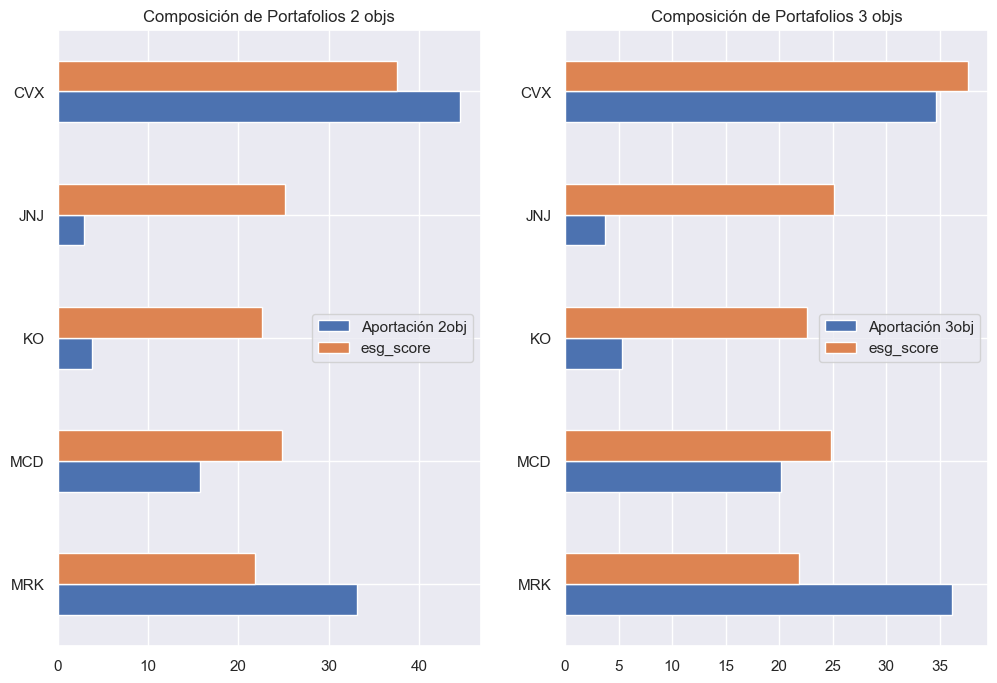

In [62]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
(assets_proportion[['Aportación 2obj','esg_score']]*100).plot(kind='barh', ax=ax[0])
(assets_proportion[['Aportación 3obj','esg_score']]*100).plot(kind='barh', ax=ax[1])
ax[0].set_title('Composición de Portafolios 2 objs')
ax[1].set_title('Composición de Portafolios 3 objs')